# Test system for function development

In [1]:
# DO NOT MODIFY BELOW

# File Handling
import os
import pickle

# Array Handling
import numpy as np
import pandas as pd

# Make Plotting Interactive
from ipywidgets import interact, fixed

# Wrapper for xraylarch (larch)
os.chdir('..')
pwd = os.getcwd()
os.chdir('./catxas')
import general as fcts
import xas as xfcts
import plot as pfcts
import process
import experiment as exp

# Plot Handling
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Where is the data?

# Directory Containing Experiment:
pickle_dir = r'D:\UU QEXAFS Workup\Nina - BF31\QEXAFS Python Workup Testing 20220922'

# Name of Experiment (must include extension '.pickle')
pickle_name = 'BF31-Fe-All.pickle'


In [3]:
# DO NOT MODIFY BELOW

pickle_path = os.path.join(pickle_dir,pickle_name)
pickle_in = open(pickle_path,"rb")
my_exp = pickle.load(pickle_in)
pickle_in.close()

# Method for Averaging (merging) Spectra


In [64]:
from larch.io import merge_groups
import datetime

In [105]:
def parse_list(m, n):
    '''
    m = list of names
    
    n = how many items should be grouped together
    
    last value is a list of remainders
    
    returns a list of lists (lenght n) with the last list the modulo m%n (remainder)
    '''
    # using list comprehension
    x = [m[i:i + n] for i in range(0, len(m), n)]
    
    return x

In [106]:
def groups_lists(exp, grp_name_list, spectra_name = 'mu sample'):
    grp_list = []
    for key in exp.spectra.keys():
        if key in grp_name_list:
            grp_list.append(exp.spectra[key]['Absorption Spectra'][spectra_name])
    
    return grp_list

In [107]:
def process_concat(exp, grp_name_list):
    process_df_list = []
    for key in exp.spectra.keys():
        if key in grp_name_list:
            process_df_list.append(exp.spectra[key]['Process Values'])
            
    process_df = pd.concat(process_df_list)
    
    process_df.drop(columns=['File Name'], inplace = True)
    
    process_df.reset_index(drop = True, inplace = True)
    
    return process_df

In [140]:
def time_lists(exp, grp_name_list):
    time_list = []
    for key in exp.spectra.keys():
        if key in grp_name_list:
            time_list.append(exp.spectra[key]['Time'])
            
    return time_list

In [154]:
def merge_spectra(exp, grp_name_list, spectra_name = 'mu Sample'):
    
    # Create List of Groups
    grp_list = groups_lists(my_exp, grp_name_list, spectra_name = spectra_name)
    
    # Create list of Process Parameters
    process_params_list = process_concat(my_exp, grp_name_list)
    
    # Create list of Timestamps
    time_list = time_lists(my_exp, grp_name_list)
    
    # Calculate the mean absorption spectra
    grp_mean = merge_groups(grp_list, master = None, 
                          xarray = 'energy', yarray = 'mu', 
                          kind = 'cubic', trim = True, calc_yerr = True)
    
    # Calculate the mean Process Paramters
    process_mean = process_params.mean(axis = 0)
    
    # Calculate the mean Timestamp
    time_mean = pd.Timestamp(np.mean([i.timestamp() for i in time_list]), unit = 's')
    
    # Rename group based upon TOS
    grp_mean.__name__ = f'{process_mean["TOS [s]"]:0.2f} s'
    
    
    # Create Spectra dictionary for experiment class
    spectra_dict = {'XAS Data Structure': None, 
                    'Time': time_mean, 
                    'Absorption Spectra':{'mu Sample': grp_mean},
                    'Process Values':process_mean
                   }
    
    return spectra_dict
    
    

In [158]:
# Down select step to set which groups to merge

spectra_list = list(my_exp.spectra.keys())

specta_to_merge = 9

list_of_group_names = parse_list(spectra_list, specta_to_merge)

In [159]:
list_of_group_names[0]

['20211119_ME_BF31_Fe_B_00003',
 '20211119_ME_BF31_Fe_B_00005',
 '20211119_ME_BF31_Fe_B_00007',
 '20211119_ME_BF31_Fe_B_00009',
 '20211119_ME_BF31_Fe_B_00011',
 '20211119_ME_BF31_Fe_B_00013',
 '20211119_ME_BF31_Fe_B_00015',
 '20211119_ME_BF31_Fe_B_00017',
 '20211119_ME_BF31_Fe_B_00019']

In [160]:
test_spectra = merge_spectra(my_exp, list_of_group_names[0], spectra_name = 'mu Sample' )

In [161]:
test_spectra

{'XAS Data Structure': None,
 'Time': Timestamp('2021-11-19 16:02:23.137300014'),
 'Absorption Spectra': {'mu Sample': <Group -61.00 s>},
 'Process Values': TOS [s]      -6.100440e+01
 H2            1.378016e-07
 He            4.095101e-08
 CH4          -1.155835e-11
 H2O           1.557460e-09
                   ...     
 Extra DO 1    0.000000e+00
 Extra DO 2    0.000000e+00
 Extra DO 3    0.000000e+00
 Extra DO 4    0.000000e+00
 Events                 NaN
 Length: 80, dtype: float64}

(3.0, 3.7)

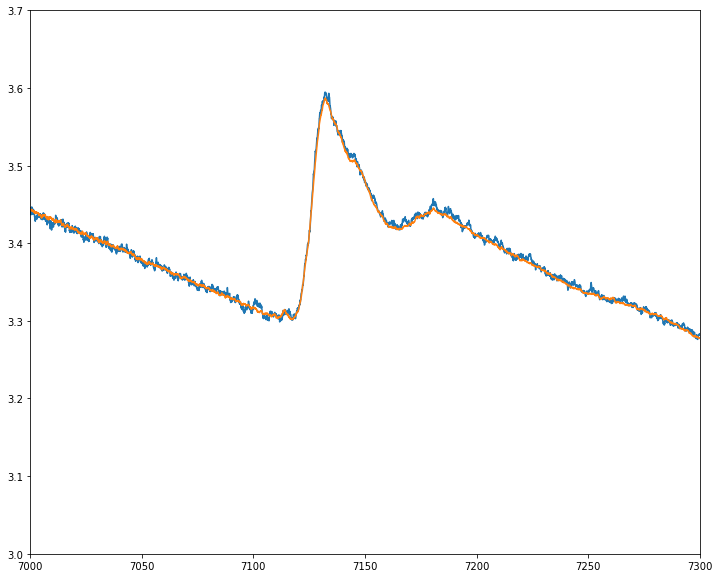

In [163]:
x1 = my_exp.spectra['20211119_ME_BF31_Fe_B_00003']['Absorption Spectra']['mu Sample'].energy
y1 = my_exp.spectra['20211119_ME_BF31_Fe_B_00003']['Absorption Spectra']['mu Sample'].mu

x2 = test_spectra['Absorption Spectra']['mu Sample'].energy
y2 = test_spectra['Absorption Spectra']['mu Sample'].mu

plt.figure(figsize = (12,10))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim(7000, 7300)
plt.ylim(3,3.7)

In [89]:
boxcar_list(list(my_exp.spectra.keys()),9)[-1]

['20211119_ME_BF31_Fe_B_05088',
 '20211119_ME_BF31_Fe_B_05090',
 '20211119_ME_BF31_Fe_B_05092',
 '20211119_ME_BF31_Fe_B_05094']

In [ ]:
def boxcar_average(m, window):
    if window > len(m):
        print('window too large')
    else:
        bins = int(len(m)/window)
        
        counter = 0
        
        averaged_m = []

        # Binned Space
        for i in range(bins):
            binned_m = []
            for j in range(window):
                binned_m.append(m[i*window+j])
                ave_val = np.mean(binned_m)
                std_val = np.std(binned_m)
                counter = counter + 1
            averaged_m.append([ave_val, std_val])

        
        result = np.asarray(averaged_m)

        return result

In [ ]:
start = 0
stop = 2
num = 100
x = np.linspace(start, stop, num = num)

In [ ]:
y1 = np.sin(np.multiply(np.pi,x))

In [ ]:
data = {'x':x,
       'y1':y1}

df = pd.DataFrame(data).set_index('x')

In [ ]:
y2 = df.y1.rolling(4, min_periods=None, center=False, 
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').mean()

y2_error = df.y1.rolling(4, min_periods=None, center=False, 
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').std()



y3 = df.y1.rolling(9, min_periods=None, center=False,
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').mean()
y3_error = df.y1.rolling(9, min_periods=None, center=False, 
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').std()

y4 = df.y1.rolling(16, min_periods=None, center=False,
                     win_type=None, on=None, axis=0,
                     closed=None, method='single').mean()
y4_error = df.y1.rolling(16, min_periods=None, center=False,
                     win_type=None, on=None, axis=0,
                     closed=None, method='single').std()

plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y2, yerr=y2_error, fmt = 'rx', capsize = 2, label = 'Rolling = 4')
plt.errorbar(x, y3, yerr=y3_error, fmt = 'bx', capsize = 2, label = 'Rolling = 9')
plt.errorbar(x, y4, yerr=y4_error, fmt = 'gx', capsize = 2, label = 'Rolling = 16')
plt.legend()
plt.title('Center False')

In [ ]:
y5 = df[key].rolling(4, min_periods=None, center=True, 
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').mean()
y5_error = df[key].rolling(4, min_periods=None, center=True, 
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').std()

y6 = df[key].rolling(9, min_periods=None, center=True,
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').mean()
y6_error = df[key].rolling(9, min_periods=None, center=True,
                     win_type=None, on=None, axis=0, 
                     closed=None, method='single').std()

y7 = df[key].rolling(16, min_periods=None, center=True,
                     win_type=None, on=None, axis=0,
                     closed=None, method='single').mean()
y7_error = df[key].rolling(16, min_periods=None, center=True,
                     win_type=None, on=None, axis=0,
                     closed=None, method='single').std()

plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y5, yerr=y5_error, fmt = 'rx', capsize = 2, label = 'Rolling = 4')
plt.errorbar(x, y6, yerr=y6_error, fmt = 'bx', capsize = 2, label = 'Rolling = 9')
plt.errorbar(x, y7, yerr=y7_error, fmt = 'gx', capsize = 2, label = 'Rolling = 16')
plt.legend()
plt.title('Center True')

In [ ]:
# Comparison of Center True/False for one set
plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y2, yerr=y2_error, fmt = 'rx', capsize = 2, label = 'Center = False')
plt.errorbar(x, y5, yerr=y5_error, fmt = 'bx', capsize = 2, label = 'Center = True')
plt.legend()
plt.title('Center True vs False, Rolling = 4')

In [ ]:
y8 = df[key].rolling(4, min_periods=None, center=True, 
                     win_type='boxcar', on=None, axis=0, 
                     closed=None, method='single').mean()
y8_error = df[key].rolling(4, min_periods=None, center=True, 
                     win_type='boxcar', on=None, axis=0, 
                     closed=None, method='single').std()

y9 = df[key].rolling(9, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0, 
                     closed=None, method='single').mean()
y9_error = df[key].rolling(9, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0, 
                     closed=None, method='single').std()

y10 = df[key].rolling(16, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed=None, method='single').mean()
y10_error = df[key].rolling(16, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed=None, method='single').std()


plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y8, yerr=y8_error, fmt = 'rx', capsize = 2, label = 'Rolling = 4')
plt.errorbar(x, y9, yerr=y9_error, fmt = 'bx', capsize = 2, label = 'Rolling = 9')
plt.errorbar(x, y10, yerr=y10_error, fmt = 'gx', capsize = 2, label = 'Rolling = 16')
plt.legend()
plt.title('Center True, Window = Boxcar')

In [ ]:
# Comparison of Center True/False for one set
plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y7, yerr=y7_error, fmt = 'rx', capsize = 2, label = 'Window = None')
plt.errorbar(x, y10, yerr=y10_error, fmt = 'bx', capsize = 2, label = 'Window = boxcar')
plt.legend()
plt.title('Window None/boxcar, Rolling = 16')

In [ ]:
y11 = df[key].rolling(4, min_periods=None, center=True, 
                     win_type='boxcar', on=None, axis=0, 
                     closed='right', method='single').mean()
y11_error = df[key].rolling(4, min_periods=None, center=True, 
                     win_type='boxcar', on=None, axis=0, 
                     closed='right', method='single').std()

y12 = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0, 
                     closed='left', method='single').mean()
y12_error = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0, 
                     closed='left', method='single').std()

y13 = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed='both', method='single').mean()
y13_error = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed='both', method='single').std()

y14 = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed='neither', method='single').mean()
y14_error = df[key].rolling(4, min_periods=None, center=True,
                     win_type='boxcar', on=None, axis=0,
                     closed='neither', method='single').std()

plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(x, y11, yerr=y11_error, fmt = 'rx', capsize = 2, label = 'Right')
plt.errorbar(x, y12, yerr=y12_error, fmt = 'bx', capsize = 2, label = 'Left')
plt.errorbar(x, y13, yerr=y13_error, fmt = 'gx', capsize = 2, label = 'Both')
plt.errorbar(x, y14, yerr=y14_error, fmt = 'gx', capsize = 2, label = 'Neither')
plt.legend()
plt.title('Rolling = 4, Center True, Window = Boxcar')

In [ ]:
win = 4

ave_x = boxcar_average(x, win)
ave_y = boxcar_average(y1, win)

win1 = 9

ave_x1 = boxcar_average(x, win1)
ave_y1 = boxcar_average(y1, win1)

In [ ]:
plt.figure(figsize = (12,10))
plt.plot(x, y1, 'k', label = 'data')
plt.errorbar(ave_x[:,0], ave_y[:,0], xerr=ave_x[:,1], yerr=ave_y[:,1], fmt = 'rx', capsize = 2, label = 'Right')
plt.errorbar(ave_x1[:,0], ave_y1[:,0], xerr=ave_x1[:,1], yerr=ave_y1[:,1], fmt = 'bx', capsize = 2, label = 'Right')